#### Objectives:
1. produce a gene occurence figure to show the distribution of genes in the pan-genome among different genomes
2. produce a gene presence/absence table
3. produce a list of fasta files, of which each contains proteins sequences in the same ortholog group.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO
import os

In [2]:
def process_OG_line(line):
    # line is a line in output file of orthomcl. Each line is a ortholog group
    # return og_id and genome list
    cont = line.strip().split(':')
    return cont[0].strip(),[item.split('_')[0] for item in cont[1].split()]

In [3]:
def load_genomes_in_each_cluster(clsterfile):
    # input clsterfile: is a cluter file generated by orthomcl
    # return a dictionary {OG_id:list(unique genomes)}
    # 
    og_genoms = dict()
    
    for line in open(clsterfile):
        if ':' not in line: continue
        og_id,genoms = process_OG_line(line)
        og_genoms[og_id] = list(set(genoms))
    print('Number of gene groups:',len(og_genoms))
    return og_genoms

In [4]:
def calculate_gene_occurence(og_genoms):
    # return a list which contains the gene occruency of each gene (group)
    # 
    
    # 1.get total number of genomes
    all_genomes = []
    for genoms in og_genoms.values(): all_genomes+=genoms
    
    tot_genome_num = float(len(set(all_genomes)))
    print('Number of genomes:',tot_genome_num)
    
    occrs = [len(genoms)/tot_genome_num for genoms in og_genoms.values()]
    return occrs

In [ ]:
def plot_gene_occurence(og_genoms,outname):
    #  produce a histogram
    # 
    occrs = calculate_gene_occurence(og_genoms)
    plt.figure(figsize=(4,3))
    plt.hist(occrs,50)
    plt.xlabel('Frequency of occurence')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(outname)
    plt.show()

#### 1. gene occurance 

Number of gene groups: 233478
Number of genomes: 343.0


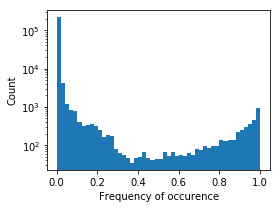

In [6]:
og_genoms = load_genomes_in_each_cluster('../data/orthomcl_output/orthomcl_clusters.txt')
plot_gene_occurence(og_genoms,'../figures/pan_genome_gene_occurence.pdf')

#### 2. gene presence absence table
Index: species name  
Columns: S228C genes. For those ones without S228C genes, use ortho ID
For those orthogroups with multiple genes from S288C, randomly choose one

In [33]:
def load_idmap(idmapfile):
    # idmapfile: orthomcl_SeqIDs_index.txt
    gid2orgid = dict() 
    for line in open(idmapfile): 
        cont = line.strip().split(':')
        gid2orgid[cont[0].strip()] = cont[1].strip()
    print(list(gid2orgid.items())[:10])
    print('Number of genes:',len(gid2orgid))
    return gid2orgid

In [34]:
def produce_gene_pa_table(orthofile,idmapfile,outname):
    # orthofile: orthomcl_clusters.txt
    
    gid2orgid = load_idmap(idmapfile)
    
    org_ref = dict() # {(org,ref_id):True}
    orgs = dict()
    refs = dict()
    for group in open(orthofile):
        cont = group.strip().split(':')
        orthoid = cont[0].strip()
        genes = [item for item in cont[1].split()]
        
        # find one reference gene
        ref = orthoid
        for gene in genes:
            org = gid2orgid[gene].split('@')[0]
            orgs[org] = True
            if org == 'Saccharomyces_cerevisiae': 
                ref = gid2orgid[gene].split('@')[1]
                break
        refs[ref] = True
        for gene in genes:
            org = gid2orgid[gene].split('@')[0]
            org_ref[(org,ref)] = True
    print('Number of gene pairs:',len(org_ref))
    # produce a tsv file
    index = list(orgs.keys())
    index.sort()
    
    columns = list(refs.keys())
    columns.sort()
    
    data = np.zeros((len(index),len(columns)))
    for i,org in enumerate(index):
        for j,ref in enumerate(columns):
            if org_ref.get((org,ref),False): data[i,j] = 1
    
    df = pd.DataFrame(data=data,index=index,columns=columns,dtype=int)
    print(df.shape)
    df.to_csv(outname)

In [35]:
def produce_one_fasta_for_each_gene_cluster(fafile,orthofile,idmapfile,outdir):
    # load seqs
    seqs = SeqIO.to_dict(SeqIO.parse(fafile,'fasta'))
    gid2orgid = load_idmap(idmapfile)
    for group in open(orthofile):
        cont = group.strip().split(':')
        orthoid = cont[0].strip()
        genes = [item for item in cont[1].split()]
        
        if len(genes)<2: continue
        fhand = open(os.path.join(outdir,'{0}.fasta'.format(orthoid)),'w')
        sub_seqs = [seqs[gid2orgid[gene]] for gene in genes]
        SeqIO.write(sub_seqs,fhand,'fasta')
        fhand.close()

In [30]:
produce_gene_pa_table('../data/orthomcl_output/orthomcl_clusters.txt',
                      '../data/orthomcl_output/orthomcl_SeqIDs_index.txt',
                      '../data/orthomcl_output/gene_pa_table.csv')

[('186_7100', 'yHMPu5000034631_Martiniozyma_abiesophila@Seq_7101'), ('272_4809', 'yHMPu5000035048_Barnettozyma_salicaria@Seq_4810'), ('84_6277', 'Metschnikowia_matae@Seq_6278'), ('74_1964', 'Metschnikowia_continentalis@Seq_1965'), ('49_2508', 'Kazachstania_naganishii@Seq_2509'), ('339_4404', 'yHMPu5000041862_Candida_golubevii@Seq_4405'), ('79_1102', 'Metschnikowia_hibisci@Seq_1103'), ('21_2590', 'Candida_infanticola@Seq_2591'), ('278_782', 'yHMPu5000035268_Wickerhamomyces_hampshirensis@Seq_783'), ('277_5417', 'yHMPu5000035261_Candida_ponderosae@Seq_5418')]
Number of genes: 2012541
Number of gene pairs: 1834191
(343, 233478)


In [37]:
outdir = '../data/orthomcl_output/gene_clusters'
if not os.path.exists(outdir): os.mkdir(outdir)
produce_one_fasta_for_each_gene_cluster('../data/orthomcl_output/343taxa_proteins.fasta',
                                        '../data/orthomcl_output/orthomcl_clusters.txt',
                                        '../data/orthomcl_output/orthomcl_SeqIDs_index.txt',
                                        outdir)

[('186_7100', 'yHMPu5000034631_Martiniozyma_abiesophila@Seq_7101'), ('272_4809', 'yHMPu5000035048_Barnettozyma_salicaria@Seq_4810'), ('84_6277', 'Metschnikowia_matae@Seq_6278'), ('74_1964', 'Metschnikowia_continentalis@Seq_1965'), ('49_2508', 'Kazachstania_naganishii@Seq_2509'), ('339_4404', 'yHMPu5000041862_Candida_golubevii@Seq_4405'), ('79_1102', 'Metschnikowia_hibisci@Seq_1103'), ('21_2590', 'Candida_infanticola@Seq_2591'), ('278_782', 'yHMPu5000035268_Wickerhamomyces_hampshirensis@Seq_783'), ('277_5417', 'yHMPu5000035261_Candida_ponderosae@Seq_5418')]
Number of genes: 2012541
